### Load Package

In [ ]:
### Load package
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## if there seems to be inconsistency due to numpy & pandas versions, do the following
!uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system
!uv pip install -q --force-reinstall pandas==2.2.2 --system

## You may need to restart colab kernel

Using Python 3.11.11 environment at: /usr
Uninstalled 2 packages in 169ms
 - numpy==1.26.4
 - pandas==2.2.2


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation

/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation


### Modify data format

In [ ]:
import pandas as pd

# Load the Excel file
file_path = "Chronos_PdM_modified_slope_calc.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)  # Read all sheets

# Dictionary to store modified sheets
modified_sheets = {}

for sheet_name, df in all_sheets.items():
    # Rename the second column to "target"
    df.columns = ['timestamp', 'target']  # Assume the original second column was the variable

    # Add "item_id" column as the first column
    df.insert(0, 'item_id', 1)

    # Rename "datetime" to "timestamp" and format it as "%Y-%m-%d %H:%M:%S"
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

    # Store modified DataFrame
    modified_sheets[sheet_name] = df

# Save the modified data into a new Excel file
output_file = "Chronos_PdM_modified_slope_calc_reformat.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in modified_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Processing complete. Saved as 'Chronos_PdM_modified_slope_calc_reformat.xlsx'.")

Processing complete. Saved as 'Chronos_PdM_modified_slope_calc_reformat.xlsx'.


### Do the task now, model evaluation metrics and slope calculation MSE & MAE are stored in xlsx sheet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define prediction length
prediction_length = 100

# Load Excel file with multiple sheets
file_path = "Chronos_PdM_modified_slope_calc_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None)

#### Chronos Blot_small

In [ ]:
# Data storage for leaderboard and slope errors
leaderboard_results = []
slope_errors = []

# Loop over all sheets (time series datasets)
for series_name, data in all_series.items():
    print(f"Processing {series_name}...")

    # Convert to TimeSeriesDataFrame
    data_slope = TimeSeriesDataFrame.from_data_frame(data)

    # Train-test split
    train_data, test_data = data_slope.train_test_split(prediction_length)

    # Set-up Chronos model
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_small"
    )

    # Make predictions
    predictions = predictor.predict(train_data)

    # Evaluate leaderboard
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)  # Add identifier
    leaderboard_results.append(leaderboard_df)

    # Extract forecasted and actual values
    yhat1 = predictions['mean']
    y1 = test_data.iloc[-100:]['target']  # Last 100 points
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute slopes
    x = np.arange(len(result_df))
    slope_y, _ = np.polyfit(x, result_df['y1'], 1)
    slope_yhat, _ = np.polyfit(x, result_df['yhat1'], 1)

    # Compute MSE and MAE between slopes
    mse_slope = mean_squared_error([slope_y], [slope_yhat])
    mae_slope = mean_absolute_error([slope_y], [slope_yhat])

    # Store slope error results
    slope_errors.append({'time_series': series_name, 'MSE_slope': mse_slope, 'MAE_slope': mae_slope})

# Save leaderboard results
leaderboard_results_df = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_file = "Chronos_slope_calc_Leaderboard_Results_bolt_small.xlsx"
leaderboard_results_df.to_excel(leaderboard_file, index=False)

# Save slope error results
slope_errors_df = pd.DataFrame(slope_errors)
slope_errors_file = "Chronos_Slope_Results.xlsx"
slope_errors_df.to_excel(slope_errors_file, index=False)

print("Processing complete! Saved leaderboard and slope error results.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185150'


Processing Machine_1...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.91 GB / 12.67 GB (86.1%)
Disk Space Avail:   61.96 GB / 107.72 GB (57.5%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following c

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185219'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_2...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185220'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_3...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185221'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_4...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185223'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_5...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185224'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_6...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185226'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_7...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185227'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_8...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185229'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_9...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185230'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_10...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185231'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_11...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185232'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_12...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185234'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_13...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185235'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_14...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185236'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_15...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185238'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.75 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_16...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185239'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_17...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185241'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_18...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185242'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_19...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185243'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_20...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185244'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_21...



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 18:52:45
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185246'
=================== System Info ===================
AutoGluon Version:  1.2
Py

Processing Machine_22...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185247'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.48 GB / 12.67 GB (82.7%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 

Processing Machine_23...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185249'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.48 GB / 12.67 GB (82.7%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_24...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185251'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_25...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185254'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_26...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185255'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_27...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185256'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_28...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185258'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_29...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.10 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185300'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_30...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185301'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_31...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185303'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_32...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185305'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_33...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185306'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_34...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185308'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_35...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185309'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_36...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185310'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_37...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185312'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_38...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185313'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_39...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185314'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_40...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185316'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_41...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185317'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_42...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185319'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_43...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185321'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_44...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185322'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_45...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185323'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_46...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185325'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_47...


Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185326'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.74 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [

Processing Machine_48...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185331'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_49...


	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185333'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_50...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185335'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 G

Processing Machine_51...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185336'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_52...


Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185344'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'know

Processing Machine_53...


Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185345'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [

Processing Machine_54...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185347'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_55...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185349'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_56...


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185350'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

Processing Machine_57...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185352'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.45 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_58...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185354'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_59...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185355'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_60...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185356'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_61...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185359'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_62...


Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.13 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185400'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_63...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.10 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185402'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 G

Processing Machine_64...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185403'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_65...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185405'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_66...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185406'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_67...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185407'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_68...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185409'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_69...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185410'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_70...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185411'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_71...


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185413'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': Tru

Processing Machine_72...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185415'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 G

Processing Machine_73...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185417'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 G

Processing Machine_74...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185418'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_75...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185420'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_76...



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 18:54:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.06    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.19 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185422'
=================== System Info ===================
AutoGluon Version:  1.2
Py

Processing Machine_77...


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185423'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperpar

Processing Machine_78...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185424'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_79...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185426'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_80...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185428'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_81...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185430'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_82...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185432'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_83...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185434'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_84...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185435'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.67 GB (82.2%)
Disk Space Avail:   61.73 G

Processing Machine_85...


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 18:54:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185437'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_

Processing Machine_86...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...


Processing Machine_87...


AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185440'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.48 GB / 12.67 GB (82.7%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provide

Processing Machine_88...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185443'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_89...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185445'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_90...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185446'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_91...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185447'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.73 G

Processing Machine_92...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185449'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.72 G

Processing Machine_93...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185450'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.6%)
Disk Space Avail:   61.72 G

Processing Machine_94...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185452'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.72 G

Processing Machine_95...


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185454'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.72 G

Processing Machine_96...



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 18:54:54
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185456'
=================== System Info ===================
AutoGluon Version:  1.2
Py

Processing Machine_97...


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 18:54:56
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185458'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_

Processing Machine_98...


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185500'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.46 GB / 12.67 GB (82.5%)
Disk Space Avail:   61.72 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small


Processing Machine_99...



Starting training. Start time is 2025-03-18 18:55:00
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_185501'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       1

Processing Machine_100...



Starting training. Start time is 2025-03-18 18:55:01
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.10 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


Processing complete! Saved leaderboard and slope error results.


#### Chronos Bolt_base

In [ ]:
# Define prediction length
prediction_length = 100

# Note: this slope_error file is deleted after I got results from all models, if you
# want to replicate the process yourself, you need to run code from previous parts first
# and you may need to change file name.
slope_errors_file = "Chronos_Slope_Results.xlsx"
slope_errors_df = pd.read_excel(slope_errors_file)

# Load the dataset (assuming it's in an Excel file with 100 sheets)
file_path = "Chronos_PdM_modified_slope_calc_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None, parse_dates=True)

In [ ]:
# Storage for `bolt_base` slope errors
slope_errors_base = []
leaderboard_base_results = []

# Loop through each sheet
for series_name, data in all_series.items():
    print(f"Processing {series_name} for bolt_base...")

    # Convert to TimeSeriesDataFrame
    data_slope = TimeSeriesDataFrame.from_data_frame(data)

    # Train-test split
    train_data, test_data = data_slope.train_test_split(prediction_length)

    # Set up Chronos model with bolt_base
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_base"
    )

    # Make predictions
    predictions = predictor.predict(train_data)

    # Evaluate leaderboard
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)
    leaderboard_base_results.append(leaderboard_df)

    # Extract forecasted and actual values
    yhat1 = predictions['mean']
    y1 = test_data.iloc[-100:]['target']
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute slopes
    x = np.arange(len(result_df))
    slope_y, _ = np.polyfit(x, result_df['y1'], 1)
    slope_yhat, _ = np.polyfit(x, result_df['yhat1'], 1)

    # Compute MSE and MAE between slopes
    mse_slope = mean_squared_error([slope_y], [slope_yhat])
    mae_slope = mean_absolute_error([slope_y], [slope_yhat])

    # Store slope error results
    slope_errors_base.append({'time_series': series_name, 'MSE_slope_base': mse_slope, 'MAE_slope_base': mae_slope})

# Convert slope errors to DataFrame and merge
slope_errors_base_df = pd.DataFrame(slope_errors_base)
merged_slope_errors_df = slope_errors_df.merge(slope_errors_base_df, on='time_series', how='left')

# Save updated slope errors
updated_slope_errors_file = "Chronos_Slope_Error_Results_Updated.xlsx"
merged_slope_errors_df.to_excel(updated_slope_errors_file, index=False)

# Save leaderboard results separately
leaderboard_base_results_df = pd.concat(leaderboard_base_results, ignore_index=True)
leaderboard_base_file = "Chronos_slope_calc_Leaderboard_Results_bolt_base.xlsx"
leaderboard_base_results_df.to_excel(leaderboard_base_file, index=False)

print("Processing complete! Saved bolt_base slope errors and leaderboard.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190621'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.27 GB / 12.67 GB (81.1%)
Disk Space Avail:   60.98 GB / 107.72 GB (56.6%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time

Processing Machine_1 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:21
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_2 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:24
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190626'
=================== System Info ===================
AutoGluon Ver

Processing Machine_3 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:26
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190629'
=================== Sy

Processing Machine_4 for bolt_base...



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:29
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190632'
=================== System Info ===================
AutoGluon Version:  1.2
Python 

Processing Machine_5 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:32
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_6 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:35
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190637'
=================== Sy

Processing Machine_7 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_8 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:40
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190643'
=================== System Info ===================
AutoGluon Ver

Processing Machine_9 for bolt_base...



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:43
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190646'
=================== System Info ===================
AutoGluon Version:  1.2
Python 

Processing Machine_10 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:46
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190648'
=================== Sy

Processing Machine_11 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:48
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190650'
=================== Sy

Processing Machine_12 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:51
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190654'
=================== System Info ===================
AutoGluon Ver

Processing Machine_13 for bolt_base...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:54
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01  

Processing Machine_14 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:06:59
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190701'
=================== System Info ===================
AutoGluon Ver

Processing Machine_15 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:02
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190704'
=================== Sy

Processing Machine_16 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:04
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_17 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:06
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_18 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:09
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_19 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:12
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190714'
=================== Sy

Processing Machine_20 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:15
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190716'
=================== Sy

Processing Machine_21 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:17
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190719'
=================== System Info ===================
AutoGluon Ver

Processing Machine_22 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:20
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_23 for bolt_base...


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:22
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190727'
=================== System Info ===================
AutoGluon Ver

Processing Machine_24 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:27
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_25 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:30
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.12 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_26 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:32
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_27 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:35
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.11 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_28 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_29 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:42
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_30 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:44
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_31 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:47
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_32 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:50
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_33 for bolt_base...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:53
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01  

Processing Machine_34 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:57
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_35 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:07:59
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_36 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:02
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.20 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_37 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:05
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_38 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:08
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190810'
=================== Sy

Processing Machine_39 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:10
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190812'
=================== Sy

Processing Machine_40 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:13
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190815'
=================== Sy

Processing Machine_41 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:15
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_42 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:18
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190820'
=================== Sy

Processing Machine_43 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:21
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_44 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:24
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_45 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:26
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_46 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:29
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_47 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:32
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_48 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190837'
=================== Sy

Processing Machine_49 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:38
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_50 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:40
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.27 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_51 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:43
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.20 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_52 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:46
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_53 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:49
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_54 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:52
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_55 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:55
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_56 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:08:57
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_57 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:00
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.17 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_58 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:03
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190905'
=================== Sy

Processing Machine_59 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:06
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_60 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:08
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_61 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:11
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.14 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_62 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:14
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190917'
=================== Sy

Processing Machine_63 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:17
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190919'
=================== Sy

Processing Machine_64 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:20
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_65 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:23
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.18 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_66 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:25
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_67 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:28
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_68 for bolt_base...



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_190934'
=================== Sy

Processing Machine_69 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_70 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:37
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.17 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_71 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:39
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_72 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:42
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_73 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:45
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_74 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:48
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.15 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_75 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:50
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_76 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:53
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_77 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:55
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_78 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:09:58
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.13 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_79 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:01
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_80 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:04
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_81 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:07
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.19 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_82 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:09
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_83 for bolt_base...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:13
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01  

Processing Machine_84 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:16
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_85 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:18
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_86 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:21
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_87 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:24
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_88 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:27
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_89 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:31
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_90 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:34
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_91 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:36
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_92 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:39
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_93 for bolt_base...


Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:42
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.20 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDr

Processing Machine_94 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:45
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_95 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:47
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_96 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:50
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_97 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:53
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing Machine_98 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:56
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.16 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_99 for bolt_base...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:10:59
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.19 s
Best model: Chronos[bolt_base]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_100 for bolt_base...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:11:01
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtim

Processing complete! Saved bolt_base slope errors and leaderboard.


#### Chronos Bolt_mini

In [ ]:
# Define prediction length
prediction_length = 100

# Load `bolt_base` slope errors (previously updated)
# Note: this slope_error file is deleted after I got results from all models, if you
# want to replicate the process yourself, you need to run code from previous parts first
# and you may need to change file name.
slope_errors_file = "Chronos_Slope_Error_Results_Updated.xlsx"
slope_errors_df = pd.read_excel(slope_errors_file)

# Load dataset
file_path = "Chronos_PdM_modified_slope_calc_reformat.xlsx"
all_series = pd.read_excel(file_path, sheet_name=None)

In [ ]:
# Storage for `bolt_mini` slope errors
slope_errors_mini = []
leaderboard_mini_results = []

# Loop through each sheet
for series_name, data in all_series.items():
    print(f"Processing {series_name} for bolt_mini...")

    # Convert to TimeSeriesDataFrame
    data_slope = TimeSeriesDataFrame.from_data_frame(data)

    # Train-test split
    train_data, test_data = data_slope.train_test_split(prediction_length)

    # Set up Chronos model with bolt_mini
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data, presets="bolt_mini"
    )

    # Make predictions
    predictions = predictor.predict(train_data)

    # Evaluate leaderboard
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', series_name)
    leaderboard_mini_results.append(leaderboard_df)

    # Extract forecasted and actual values
    yhat1 = predictions['mean']
    y1 = test_data.iloc[-100:]['target']
    result_df = pd.merge(yhat1, y1, how='outer', left_index=True, right_index=True)
    result_df.columns = ['yhat1', 'y1']

    # Compute slopes
    x = np.arange(len(result_df))
    slope_y, _ = np.polyfit(x, result_df['y1'], 1)
    slope_yhat, _ = np.polyfit(x, result_df['yhat1'], 1)

    # Compute MSE and MAE between slopes
    mse_slope = mean_squared_error([slope_y], [slope_yhat])
    mae_slope = mean_absolute_error([slope_y], [slope_yhat])

    # Store slope error results
    slope_errors_mini.append({'time_series': series_name, 'MSE_slope_mini': mse_slope, 'MAE_slope_mini': mae_slope})

# Convert slope errors to DataFrame and merge
slope_errors_mini_df = pd.DataFrame(slope_errors_mini)
merged_slope_errors_final_df = slope_errors_df.merge(slope_errors_mini_df, on='time_series', how='left')

# Save updated slope errors
final_slope_errors_file = "Chronos_Slope_Error_Results_Final.xlsx"
merged_slope_errors_final_df.to_excel(final_slope_errors_file, index=False)

# Save leaderboard results separately
leaderboard_mini_results_df = pd.concat(leaderboard_mini_results, ignore_index=True)
leaderboard_mini_file = "Chronos_slope_calc_Leaderboard_Results_bolt_mini.xlsx"
leaderboard_mini_results_df.to_excel(leaderboard_mini_file, index=False)

print("Processing complete! Saved bolt_mini slope errors and leaderboard.")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_191339'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.24 GB / 12.67 GB (80.8%)
Disk Space Avail:   60.95 GB / 107.72 GB (56.6%)
Setting presets to: bolt_mini

Fitting with arguments:


Processing Machine_1 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:40
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_191343'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.23 GB / 12.67 GB (80.7%)
Disk Space Avail:   60.88 GB / 107.72 GB (56.5%)
Setting presets to: bolt_mini

Fitting with arguments:


Processing Machine_2 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:43
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_3 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:47
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.15 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_4 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:49
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.03    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.20 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_5 for bolt_mini...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.21 GB / 12.67 GB (80.6%)
Disk Space Avail:   60.88 GB / 107.72 GB (56.5%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following col

Processing Machine_6 for bolt_mini...


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:54
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_7 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:56
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.17 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_8 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:13:58
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_9 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:00
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.19 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_10 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:02
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.19 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_11 for bolt_mini...


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:06
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_12 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:08
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_13 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:10
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_14 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:12
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_15 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:14
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_16 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:16
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_17 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:19
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_18 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:21
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_19 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:23
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_20 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:25
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_21 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:27
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_22 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:29
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.15 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_23 for bolt_mini...


Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:31
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries mode

Processing Machine_24 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:33
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_25 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:35
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.18 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_26 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:37
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_27 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:39
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_28 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:40
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_29 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:43
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_30 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:45
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_31 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:47
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_32 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:50
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_33 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:51
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_34 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:14:54
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_35 for bolt_mini...


AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/AutogluonModels/ag-20250318_191456'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.17 GB / 12.67 GB (80.2%)
Disk Space Avail:   60.85 GB / 107.72 GB (56.5%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided 

Processing Machine_36 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:03
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_37 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:05
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_38 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:07
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_39 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:09
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_40 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:12
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_41 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:14
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_42 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:16
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_43 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:18
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_44 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:20
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_45 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:22
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_46 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:24
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_47 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:26
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_48 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:28
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_49 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:30
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_50 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:32
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_51 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:34
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_52 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:36
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_53 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:38
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.15 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_54 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:40
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_55 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:43
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_56 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:44
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_57 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:46
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_58 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:49
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_59 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:51
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_60 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:53
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.19 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_61 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:55
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_62 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:57
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_63 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:15:59
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_64 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:01
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_65 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:03
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_66 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:05
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.19 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_67 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:07
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_68 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:09
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_69 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:11
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_70 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:13
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_71 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:15
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_72 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:17
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_73 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:19
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_74 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:22
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_75 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:24
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_76 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:26
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_77 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:28
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_78 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:30
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_79 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:32
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_80 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:34
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_81 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:36
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_82 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:38
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_83 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:40
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_84 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:42
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_85 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:44
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_86 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:46
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.17 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_87 for bolt_mini...


Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:48
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_mini]']
Total runtime: 0.22 s
Best model: Chronos[bolt_mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Beginning AutoGluon training...
AutoGluon will

Processing Machine_88 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:50
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_89 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:52
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_90 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:55
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_91 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:57
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_92 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:16:59
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_93 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:01
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_94 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:03
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_95 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:05
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_96 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:07
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_97 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:10
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing Machine_98 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:12
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_99 for bolt_mini...


{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:14
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01    s     = Training runtim

Processing Machine_100 for bolt_mini...



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 900 rows, 1 time series. Median time series length is 900 (min=900, max=900). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-18 19:17:17
Models that will be trained: ['Chronos[bolt_mini]']
Training timeseries model Chronos[bolt_mini]. 
	0.01  

Processing complete! Saved bolt_mini slope errors and leaderboard.


### Explore the result

In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/Chronos_results

/content/drive/MyDrive/GE_Capstone/Model Test/Slope Calculation/Chronos_results


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load slope error data
slope_errors_file = "Chronos_Slope_Error_Results.xlsx"
df = pd.read_excel(slope_errors_file)

# Compute summary statistics
summary_stats = df.describe()
print(summary_stats)

       MSE_slope_small  MAE_slope_small  MSE_slope_base  MAE_slope_base  \
count       100.000000       100.000000      100.000000      100.000000   
mean          0.466631         0.635972        0.063360        0.186379   
std           0.454787         0.250598        0.164697        0.170036   
min           0.003272         0.057204        0.000015        0.003883   
25%           0.317700         0.563594        0.004873        0.069802   
50%           0.431883         0.657175        0.024043        0.155056   
75%           0.548057         0.740304        0.053293        0.230850   
max           4.348111         2.085212        1.510417        1.228990   

       MSE_slope_mini  MAE_slope_mini  
count      100.000000      100.000000  
mean         0.084999        0.229875  
std          0.170267        0.180227  
min          0.000012        0.003483  
25%          0.012236        0.110607  
50%          0.039451        0.198612  
75%          0.080769        0.284199  
max 

#### MSE plots

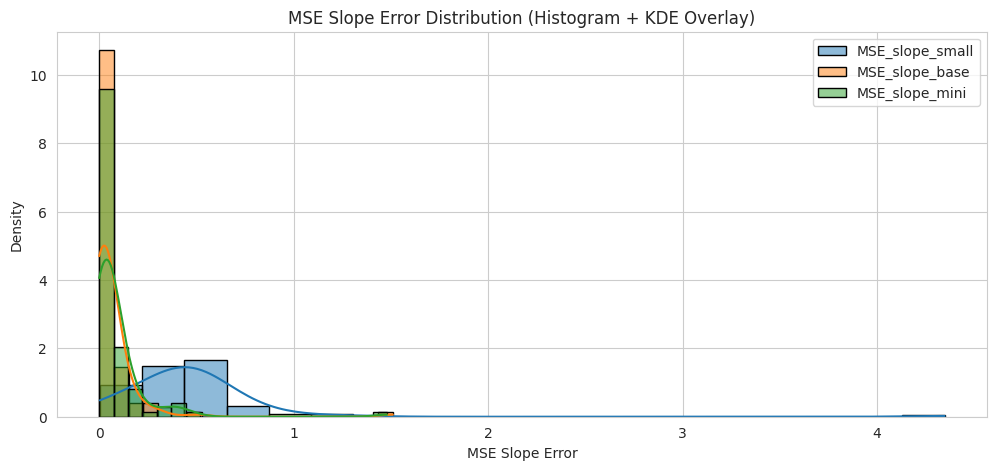

In [ ]:
# Set plot style
sns.set_style("whitegrid")

### --- MSE Histogram with KDE Overlay ---
plt.figure(figsize=(12, 5))

# Define colors
colors = {'MSE_slope_small': '#1f77b4', 'MSE_slope_base': '#ff7f0e', 'MSE_slope_mini': '#2ca02c'}

# Plot histograms with KDE overlay
for col, color in colors.items():
    sns.histplot(df[col], bins=20, kde=True, stat="density", label=col, color=color, alpha=0.5, edgecolor='black')

# Labels and title
plt.xlabel("MSE Slope Error")
plt.ylabel("Density")
plt.title("MSE Slope Error Distribution (Histogram + KDE Overlay)")
plt.legend()
plt.show()

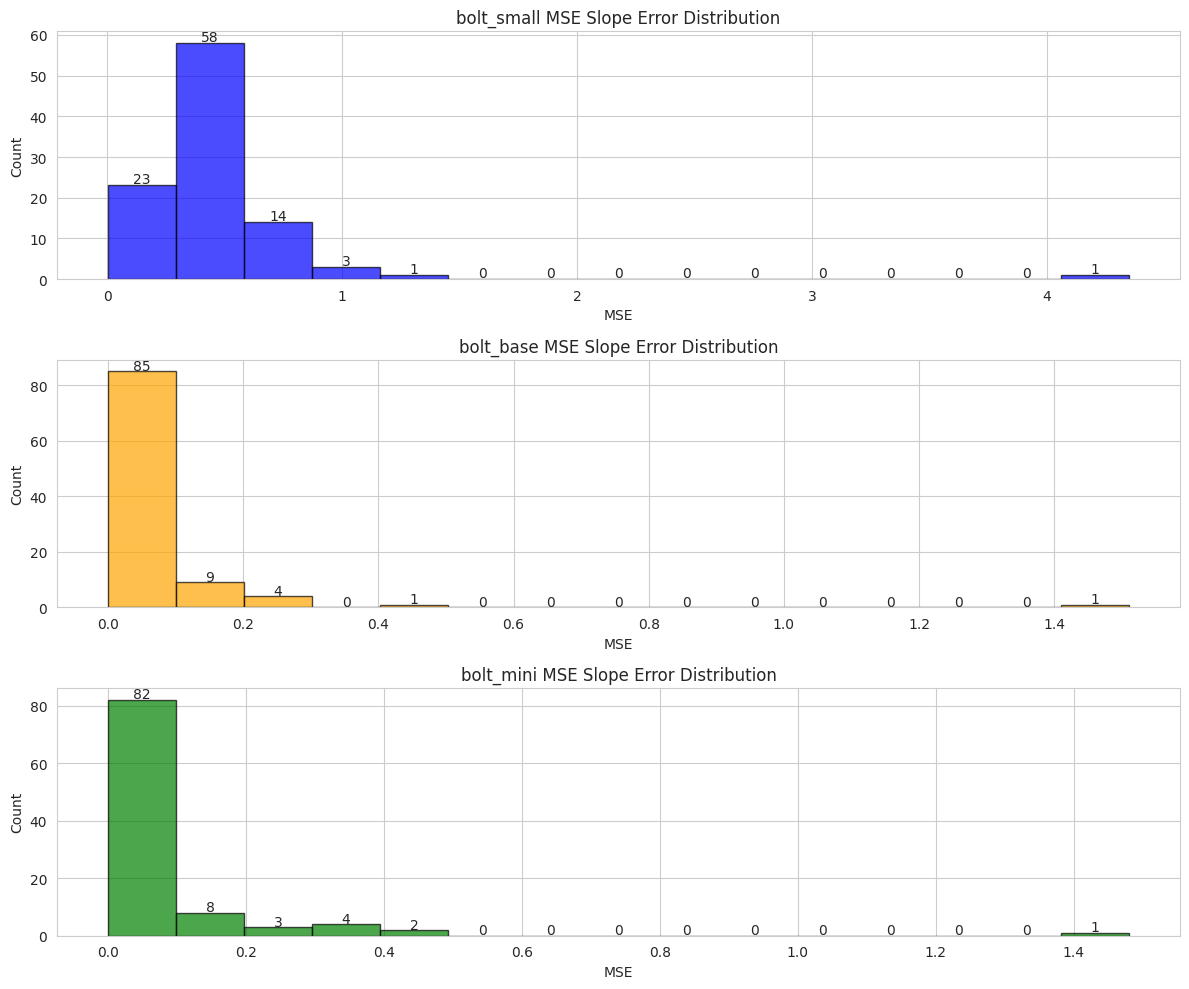

In [ ]:
### --- MSE Facet Histogram ---
# Define figure layout
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Define colors
colors = ['blue', 'orange', 'green']
labels = ['bolt_small', 'bolt_base', 'bolt_mini']
mse_cols = ['MSE_slope_small', 'MSE_slope_base', 'MSE_slope_mini']

# Loop through MSE columns
for i, col in enumerate(mse_cols):
    ax = axes[i]
    n, bins, patches = ax.hist(df[col], bins=15, alpha=0.7, color=colors[i], edgecolor='black')

    # Add count labels on top of each bar
    for count, bin_center in zip(n, (bins[:-1] + bins[1:]) / 2):
        ax.text(bin_center, count + 0.5, str(int(count)), ha='center', fontsize=10)

    ax.set_title(f"{labels[i]} MSE Slope Error Distribution")
    ax.set_xlabel("MSE")
    ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

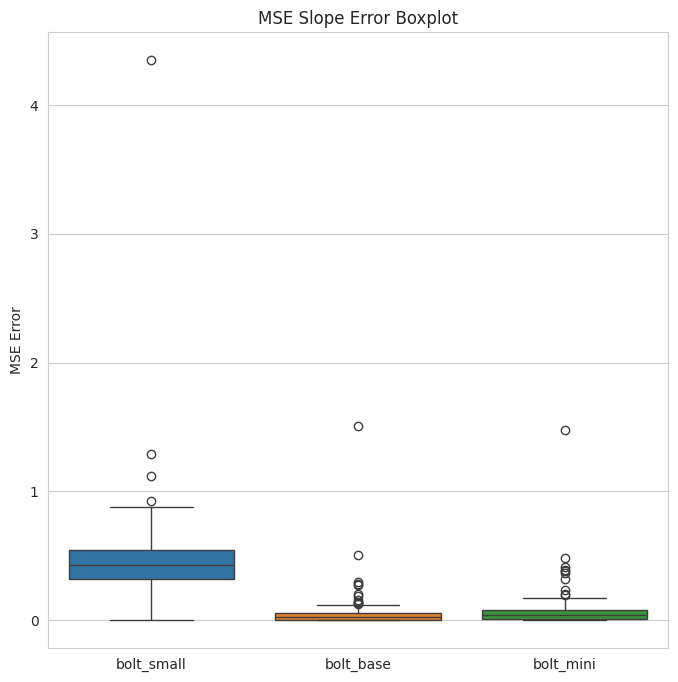

In [ ]:
### --- MSE Box Plot ---
plt.figure(figsize=(8, 8))
sns.boxplot(data=df[['MSE_slope_small', 'MSE_slope_base', 'MSE_slope_mini']])
plt.title("MSE Slope Error Boxplot")
plt.ylabel("MSE Error")
plt.xticks(ticks=[0, 1, 2], labels=['bolt_small', 'bolt_base', 'bolt_mini'])
plt.show()

In [ ]:
# Define scatter plot function
def plot_scatter(x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.7, color='blue')
    plt.plot([0, max(df[x_col].max(), df[y_col].max())],
             [0, max(df[x_col].max(), df[y_col].max())], linestyle='dashed', color='red')  # Reference line
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

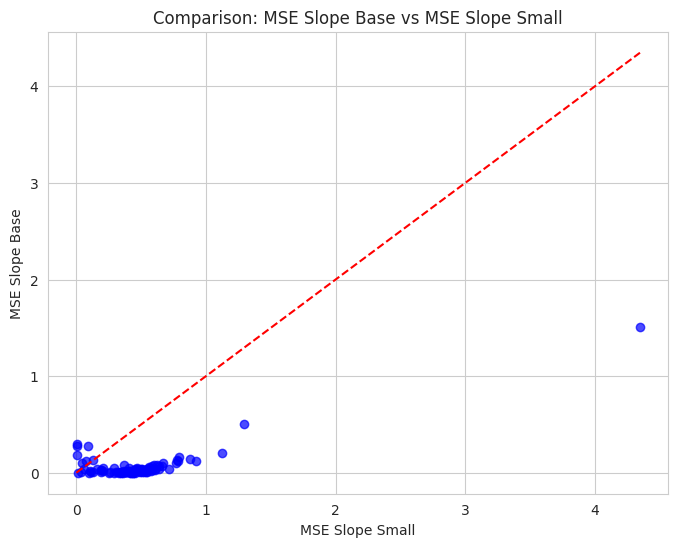

In [ ]:
# Scatter plot (MSE_slope_base vs MSE_slope_small)
plot_scatter('MSE_slope_small', 'MSE_slope_base',
             "Comparison: MSE Slope Base vs MSE Slope Small",
             "MSE Slope Small", "MSE Slope Base")

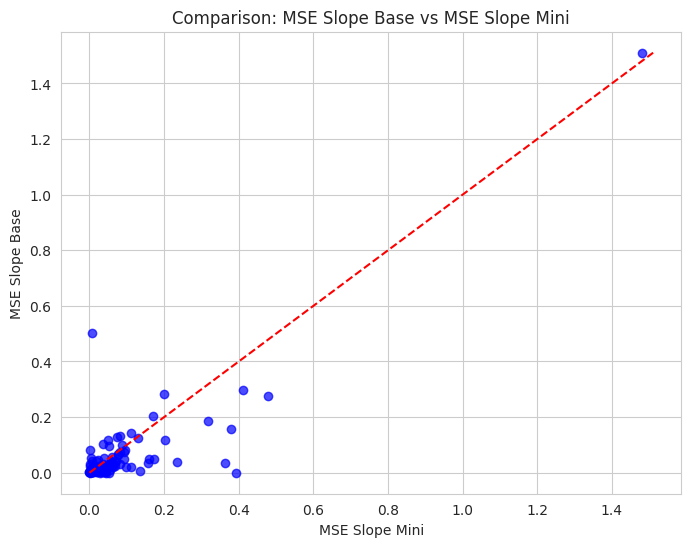

In [ ]:
# Scatter plot (MSE_slope_base vs MSE_slope_mini)
plot_scatter('MSE_slope_mini', 'MSE_slope_base',
             "Comparison: MSE Slope Base vs MSE Slope Mini",
             "MSE Slope Mini", "MSE Slope Base")

#### MAE plots

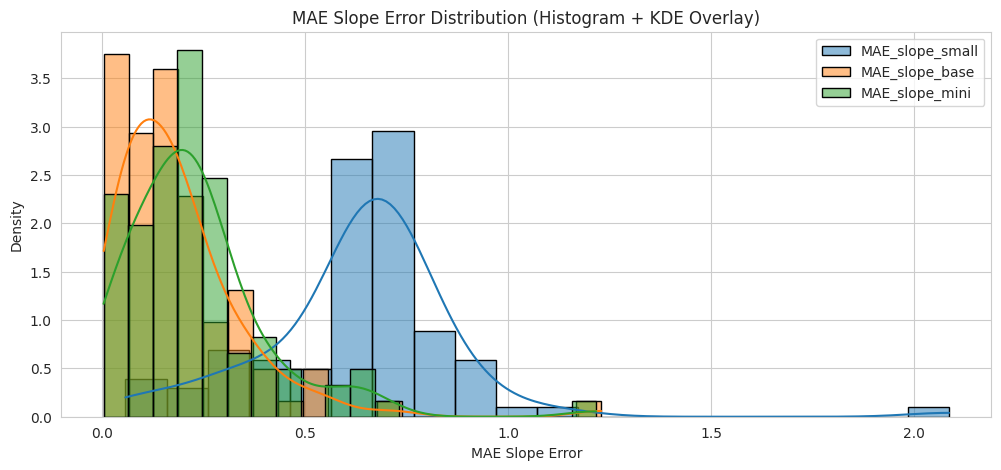

In [ ]:
### --- MAE Histogram with KDE Overlay ---
plt.figure(figsize=(12, 5))

# Define colors
colors = {'MAE_slope_small': '#1f77b4', 'MAE_slope_base': '#ff7f0e', 'MAE_slope_mini': '#2ca02c'}

# Plot histograms with KDE overlay
for col, color in colors.items():
    sns.histplot(df[col], bins=20, kde=True, stat="density", label=col, color=color, alpha=0.5, edgecolor='black')

# Labels and title
plt.xlabel("MAE Slope Error")
plt.ylabel("Density")
plt.title("MAE Slope Error Distribution (Histogram + KDE Overlay)")
plt.legend()
plt.show()

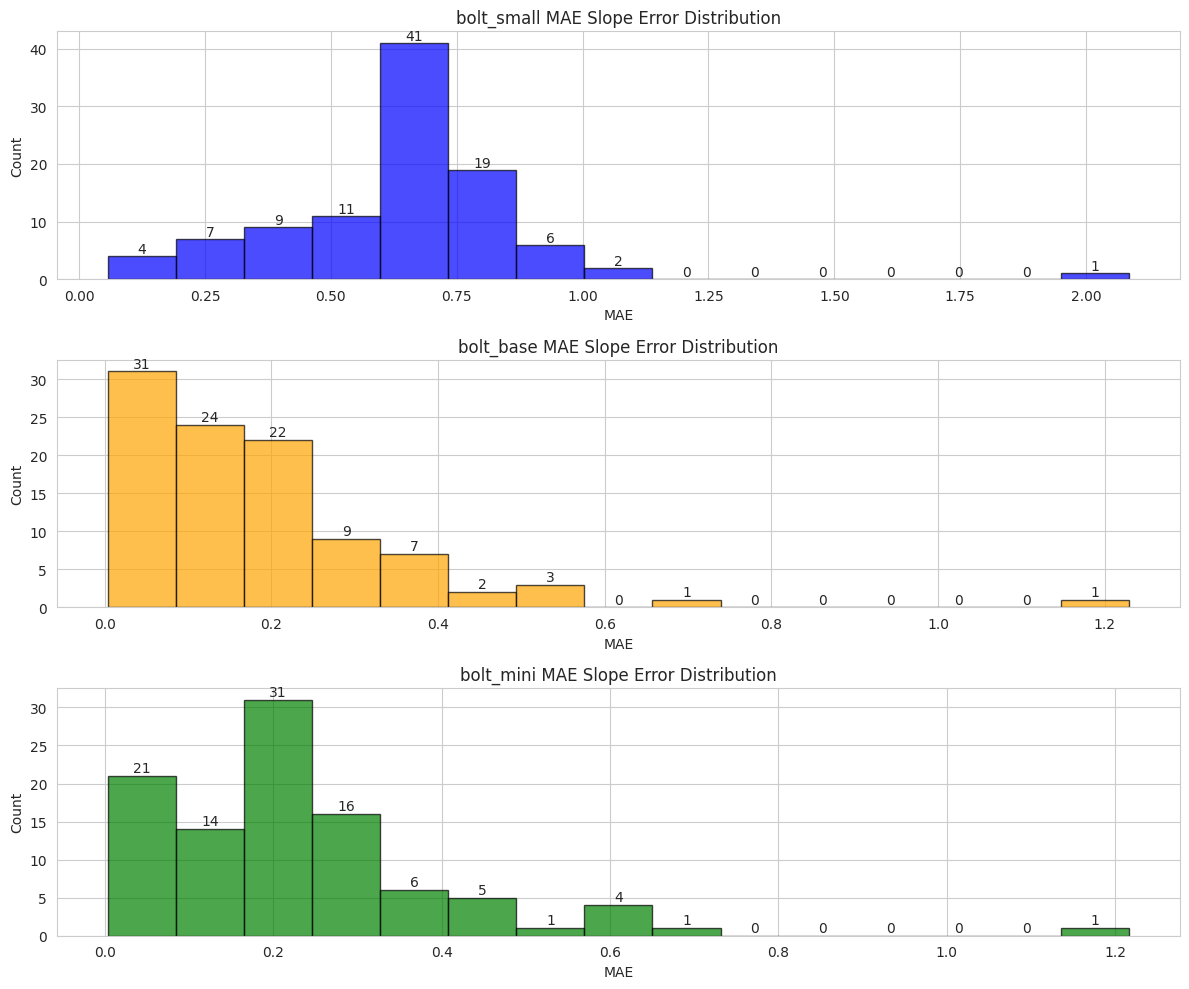

In [ ]:
### --- MAE Facet Histogram ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

mae_cols = ['MAE_slope_small', 'MAE_slope_base', 'MAE_slope_mini']

# Loop through MAE columns
for i, col in enumerate(mae_cols):
    ax = axes[i]
    n, bins, patches = ax.hist(df[col], bins=15, alpha=0.7, color=colors[i], edgecolor='black')

    # Add count labels on top of each bar
    for count, bin_center in zip(n, (bins[:-1] + bins[1:]) / 2):
        ax.text(bin_center, count + 0.5, str(int(count)), ha='center', fontsize=10)

    ax.set_title(f"{labels[i]} MAE Slope Error Distribution")
    ax.set_xlabel("MAE")
    ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

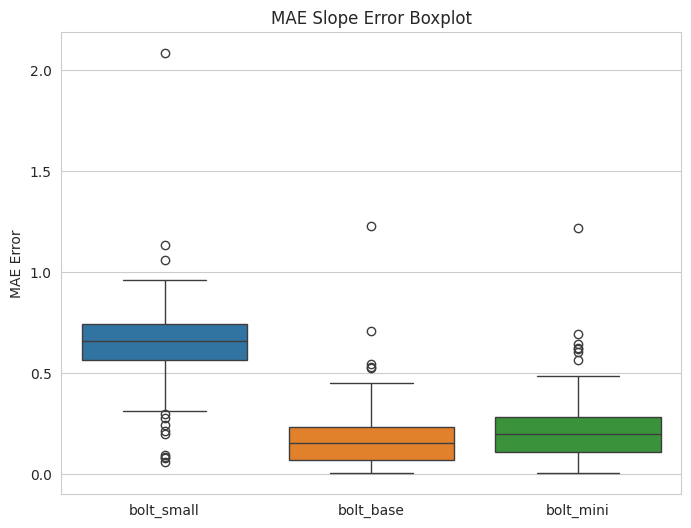

In [ ]:
### --- MAE Box Plot ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['MAE_slope_small', 'MAE_slope_base', 'MAE_slope_mini']])
plt.title("MAE Slope Error Boxplot")
plt.ylabel("MAE Error")
plt.xticks(ticks=[0, 1, 2], labels=['bolt_small', 'bolt_base', 'bolt_mini'])
plt.show()

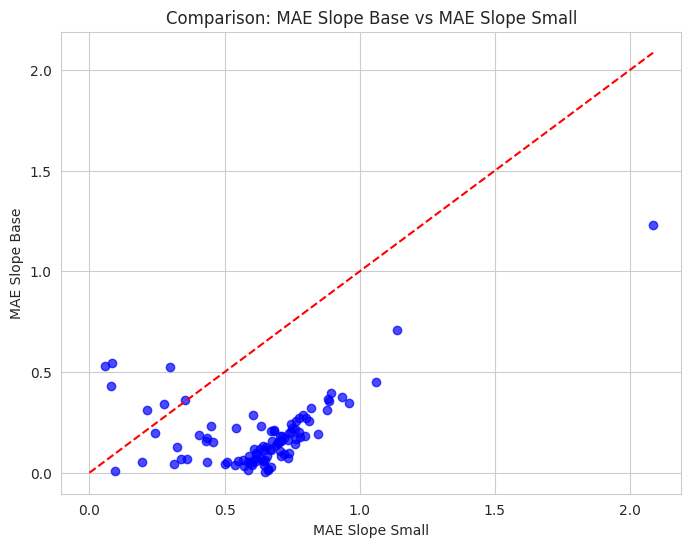

In [ ]:
# Scatter plot (MAE_slope_base vs MAE_slope_small)
plot_scatter('MAE_slope_small', 'MAE_slope_base',
             "Comparison: MAE Slope Base vs MAE Slope Small",
             "MAE Slope Small", "MAE Slope Base")

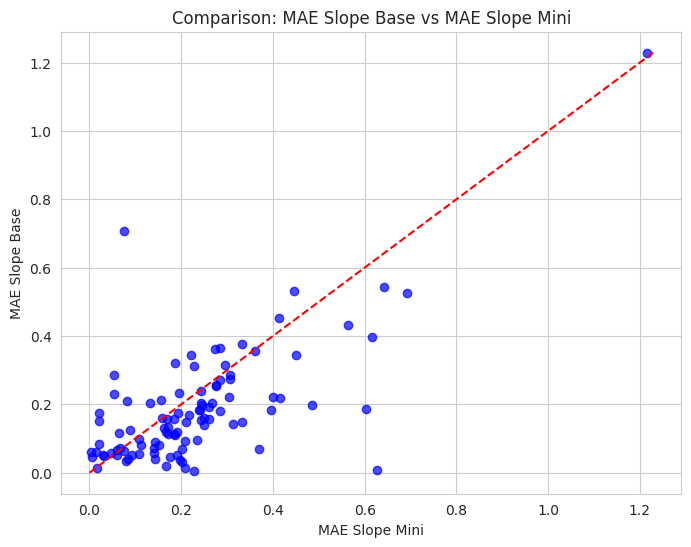

In [ ]:
# Scatter plot (MAE_slope_base vs MAE_slope_mini)
plot_scatter('MAE_slope_mini', 'MAE_slope_base',
             "Comparison: MAE Slope Base vs MAE Slope Mini",
             "MAE Slope Mini", "MAE Slope Base")

#### Difference Plots

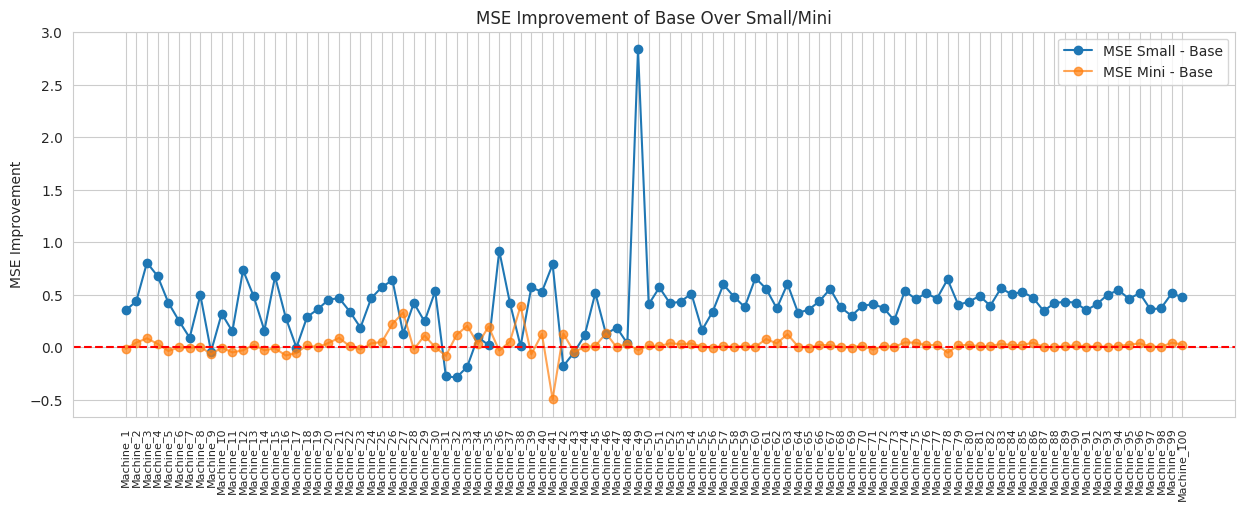

In [ ]:
# Compute differences
df['base_vs_small'] = df['MSE_slope_small'] - df['MSE_slope_base']
df['base_vs_mini'] = df['MSE_slope_mini'] - df['MSE_slope_base']

# Plot MSE improvement trend
plt.figure(figsize=(15, 5))
plt.plot(df['time_series'], df['base_vs_small'], marker='o', linestyle='-', label="MSE Small - Base")
plt.plot(df['time_series'], df['base_vs_mini'], marker='o', linestyle='-', label="MSE Mini - Base", alpha=0.7)
plt.axhline(0, color='red', linestyle='dashed')  # Reference line
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("MSE Improvement")
plt.title("MSE Improvement of Base Over Small/Mini")
plt.legend()
plt.show()

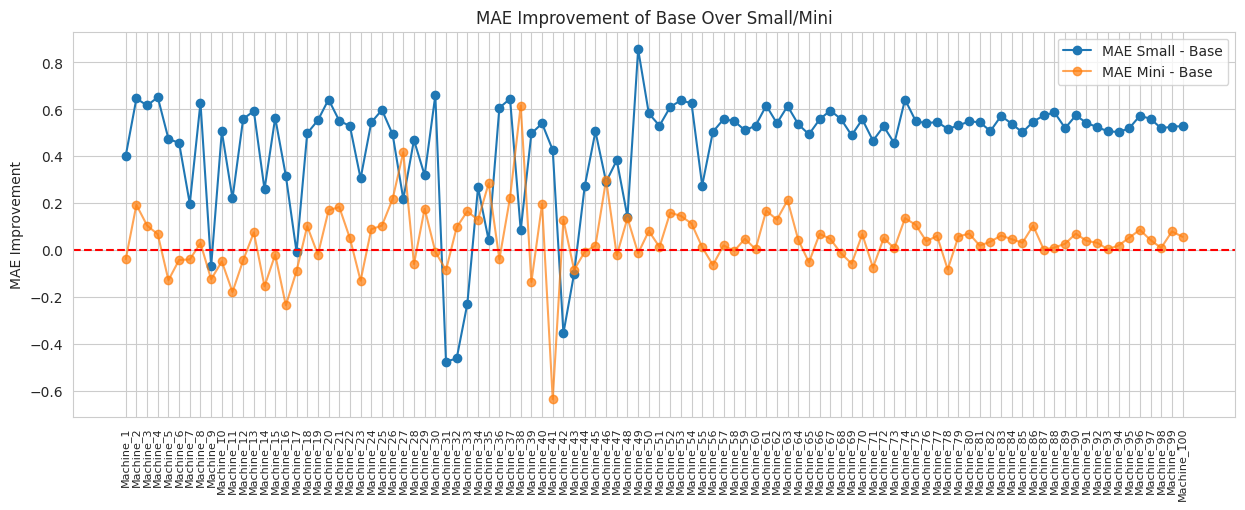

In [ ]:
# Compute differences
df['base_vs_small'] = df['MAE_slope_small'] - df['MAE_slope_base']
df['base_vs_mini'] = df['MAE_slope_mini'] - df['MAE_slope_base']

# Plot MAE improvement trend
plt.figure(figsize=(15, 5))
plt.plot(df['time_series'], df['base_vs_small'], marker='o', linestyle='-', label="MAE Small - Base")
plt.plot(df['time_series'], df['base_vs_mini'], marker='o', linestyle='-', label="MAE Mini - Base", alpha=0.7)
plt.axhline(0, color='red', linestyle='dashed')  # Reference line
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("MAE Improvement")
plt.title("MAE Improvement of Base Over Small/Mini")
plt.legend()
plt.show()

### Finding:

Since we do zero-shot forecasting here, the whole process takes only 3-4 minutes for each model size, with smaller model taking fewer time, which is quite fast.

Given 900 data points to predict 100 data points on slope calculation task, Chronos Bolt_base is much better than the other two models, though difference between Bolt_mini and Bolt_base is not that significant, especially if we consider MSE difference as shown in plot above; however, Bolt_small model gives relatively poor results throughout the 100 time series.

Notice that since we add trend and noise to the original data, signals and noises from the original time series are exaggerated in this sense, and of course magnitude of data gets larger.

Such intricate situation may be due to the following: Bolt_mini has much fewer parameters, but maybe it's just enough to capture the essential pattern in time series data here; while Bolt_base can capture the pattern in the data much better due to more powerful forecasting capabilities; but number of parameters for Bolt_small is between the previous two, maybe it's trying to capture all the complexities in the data but it's out of its capability, which may lead to poor performance.

But still, the performance is quite good, especially for bolt_base.